In [ ]:
import os
import re
import itertools
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, roc_auc_score, precision_recall_curve, auc, f1_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from collections import Counter
import itertools
import warnings

In [ ]:
pre_post_test_df = pd.read_csv('pre_post_test_analysis.csv')
behavioural_df = pd.read_csv('behavioural_analysis.csv')
fnirs_df = pd.read_csv('fnirs_analysis.csv')
eye_tracking_df = pd.read_csv('eye_tracking_analysis.csv')  

merged_df = pre_post_test_df.merge(behavioural_df, on=['participant_number', 'subexperiment_number'])
merged_df = merged_df.merge(fnirs_df, on=['participant_number', 'subexperiment_number'])
merged_df = merged_df.merge(eye_tracking_df, on=['participant_number', 'subexperiment_number']) 

merged_df.to_csv('master.csv', index=False)
print("master.csv has been updated successfully.")

master.csv has been updated successfully.


### Calculate Median and Upper Quartile Split using 9-point Paas Score

In [ ]:
file_path = "master.csv"
df = pd.read_csv(file_path)

subject_col = 'participant_number'

median_thresholds = []
quartile_thresholds = []

def perform_splits(group):
    # Calculate the subject-specific median for the 9-point Paas score
    median_value = group['feedback_score_subexperiment'].median()
    group['median_split_feedback_score_subexperiment'] = group['feedback_score_subexperiment'].apply(
        lambda x: 1 if x >= median_value else 0
    )
    
    # Calculate the subject-specific 75th percentile (upper quartile) for the 9-point Paas score
    quartile_value = group['feedback_score_subexperiment'].quantile(0.75)
    group['quartile_split_feedback_score_subexperiment'] = group['feedback_score_subexperiment'].apply(
        lambda x: 1 if x >= quartile_value else 0
    )
    
    median_thresholds.append(median_value)
    quartile_thresholds.append(quartile_value)

    print(f"Participant {group[subject_col].iloc[0]}: median = {median_value}, upper quartile = {quartile_value}")
    return group

df = df.groupby(subject_col, group_keys=False).apply(perform_splits)

# Calculate the mean thresholds across all subjects (for reporting)
mean_median_threshold = sum(median_thresholds) / len(median_thresholds)
mean_quartile_threshold = sum(quartile_thresholds) / len(quartile_thresholds)

print("\nOverall Mean Thresholds Across All Subjects:")
print(f"Mean median-based threshold: {mean_median_threshold:.2f}")
print(f"Mean upper quartile-based threshold: {mean_quartile_threshold:.2f}")
print("\nMedian split counts:")
print(df['median_split_feedback_score_subexperiment'].value_counts())
print("\nQuartile split counts:")
print(df['quartile_split_feedback_score_subexperiment'].value_counts())

cols = df.columns.tolist()
if 'median_split_feedback_score_subexperiment' in cols:
    cols.remove('median_split_feedback_score_subexperiment')
if 'quartile_split_feedback_score_subexperiment' in cols:
    cols.remove('quartile_split_feedback_score_subexperiment')

feedback_index = cols.index('feedback_score_subexperiment')
cols.insert(feedback_index + 1, 'median_split_feedback_score_subexperiment')
cols.insert(feedback_index + 2, 'quartile_split_feedback_score_subexperiment')
df = df[cols]

df.to_csv(file_path, index=False)
print(f"{file_path} saved successfully.")

Participant 2: median = 7.0, upper quartile = 7.0
Participant 3: median = 3.5, upper quartile = 6.0
Participant 4: median = 5.5, upper quartile = 7.0
Participant 10: median = 4.0, upper quartile = 5.25
Participant 15: median = 9.0, upper quartile = 9.0
Participant 16: median = 4.5, upper quartile = 6.0
Participant 20: median = 4.0, upper quartile = 5.0
Participant 21: median = 3.0, upper quartile = 5.0
Participant 22: median = 4.5, upper quartile = 5.0
Participant 23: median = 4.0, upper quartile = 6.0
Participant 24: median = 5.0, upper quartile = 5.0
Participant 25: median = 6.5, upper quartile = 7.0
Participant 26: median = 5.0, upper quartile = 6.0
Participant 27: median = 6.0, upper quartile = 6.25
Participant 28: median = 6.5, upper quartile = 7.0
Participant 29: median = 6.0, upper quartile = 7.0
Participant 30: median = 5.5, upper quartile = 6.0
Participant 31: median = 5.0, upper quartile = 5.25
Participant 32: median = 7.0, upper quartile = 8.0
Participant 33: median = 3.5, u

### Calculate Tutorial Split using 9-point Paas Score

In [ ]:
import pandas as pd

file_path = "master.csv"
df = pd.read_csv(file_path)

# Calculate the tutorial_threshold as the average of feedback_score_tutorial_2 and feedback_score_tutorial_3
df['tutorial_threshold'] = (df['feedback_score_tutorial_2'] + df['feedback_score_tutorial_3']) / 2

# Create the tutorial_split_feedback_score_subexperiment column
df['tutorial_split_feedback_score_subexperiment'] = df.apply(
    lambda row: 1 if row['feedback_score_subexperiment'] >= row['tutorial_threshold'] else 0,
    axis=1
)

columns = df.columns.tolist()
insert_index = columns.index('feedback_score_rest_1') + 1
columns.insert(insert_index, 'tutorial_threshold')
columns.insert(insert_index + 1, 'tutorial_split_feedback_score_subexperiment')
df = df[columns]

df.to_csv(file_path, index=False)
print(f"{file_path} updated with tutorial_threshold and tutorial_split_feedback_score_subexperiment columns in the correct order.")

master.csv updated with tutorial_threshold and tutorial_split_feedback_score_subexperiment columns in the correct order.


### Calculate Counts to Observe Splitting and Imbalance

In [ ]:
tutorial_split_counts = df['tutorial_split_feedback_score_subexperiment'].value_counts()

print("Counts in tutorial_split_feedback_score_subexperiment:")
print(f"0s: {tutorial_split_counts.get(0, 0)}")
print(f"1s: {tutorial_split_counts.get(1, 0)}")

Counts in tutorial_split_feedback_score_subexperiment:
0s: 109
1s: 371


### Random Forest

Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.14      0.19        22
           1       0.78      0.91      0.84        74

    accuracy                           0.73        96
   macro avg       0.54      0.52      0.51        96
weighted avg       0.67      0.73      0.69        96


Confusion Matrix:
[[ 3 19]
 [ 7 67]]


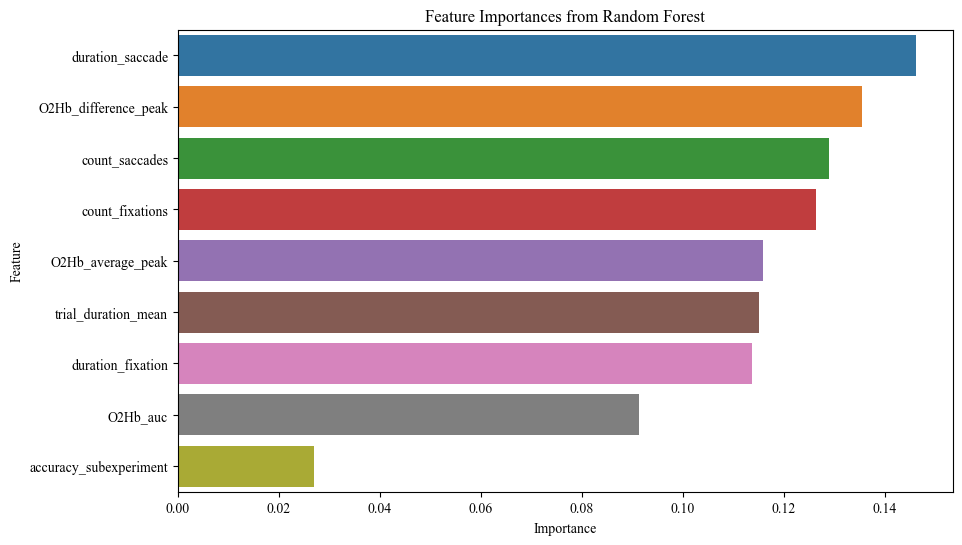

In [53]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'count_saccades', 'duration_fixation', 'duration_saccade', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Logistic Regression

In [ ]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'duration_fixation', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.77      1.00      0.87        74

    accuracy                           0.77        96
   macro avg       0.39      0.50      0.44        96
weighted avg       0.59      0.77      0.67        96


Confusion Matrix:
[[ 0 22]
 [ 0 74]]


C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

### Linear Discriminant Analysis

In [ ]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'duration_fixation', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.77      0.97      0.86        74

    accuracy                           0.75        96
   macro avg       0.38      0.49      0.43        96
weighted avg       0.59      0.75      0.66        96


Confusion Matrix:
[[ 0 22]
 [ 2 72]]


### Support Vector Machine

In [ ]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'duration_fixation', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear'],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters found: {grid.best_params_}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'C': 100, 'class_weight': None, 'gamma': 1, 'kernel': 'linear'}
Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        22
           1       0.77      1.00      0.87        74

    accuracy                           0.77        96
   macro avg       0.89      0.50      0.44        96
weighted avg       0.82      0.77      0.67        96


Confusion Matrix:
[[ 0 22]
 [ 0 74]]


### K Means Clustering

C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


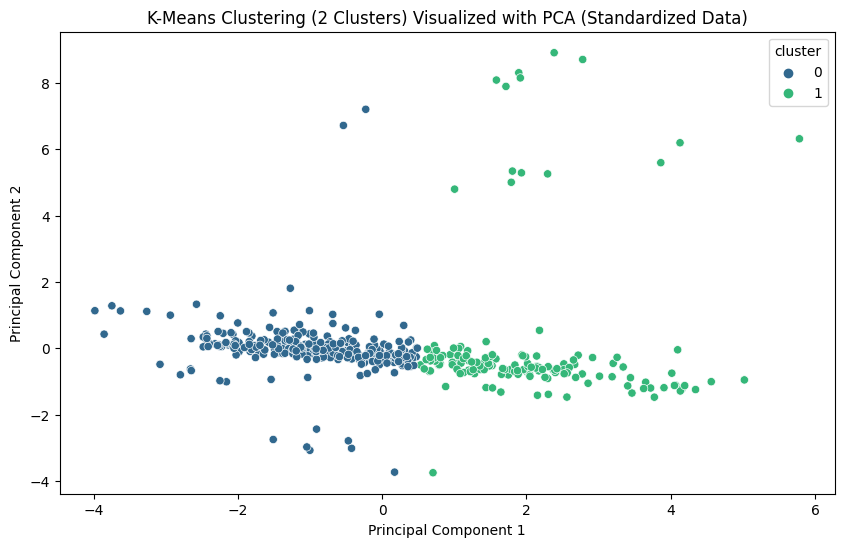

Explained variance by PC1 and PC2: [0.31029565 0.21933057]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 
        'count_fixations', 'count_saccades', 
        'duration_fixation', 'duration_saccade', 
        'accuracy_subexperiment', 'trial_duration_mean']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['cluster'] = clusters

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='viridis')
plt.title('K-Means Clustering (2 Clusters) Visualized with PCA (Standardized Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print("Explained variance by PC1 and PC2:", pca.explained_variance_ratio_)

### Unimodal Voting Classifier

In [ ]:
warnings.filterwarnings('ignore')

master_df = pd.read_csv("master.csv")

labels = [
    "median_split_feedback_score_subexperiment",
    "quartile_split_feedback_score_subexperiment",
    "tutorial_split_feedback_score_subexperiment",
    "supervised_classifier_label",
]

modalities = {
    "behavioral": ["accuracy_subexperiment", "trial_duration_mean"],
    "eye_tracking": ["count_fixations", "count_saccades", "duration_fixation", "duration_saccade"],
    "brain_activity": ["O2Hb_highest_peak", "O2Hb_difference_peak", "O2Hb_auc"],
}

base_param_grids = {
    "Logistic Regression": {
        "C": np.logspace(-3, 3, 10),
        "penalty": ["l2"],
        "solver": ["lbfgs"],
    },
    "LDA": {
        "solver": ["svd", "lsqr", "eigen"],
        "shrinkage": [None, "auto", 0.1, 0.3, 0.5, 0.7, 0.9],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    },
    "SVM": {
        "C": np.logspace(-3, 3, 10),
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
    },
    "Decision Tree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
    },
}

def weighted_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="weighted")

def bootstrap_confidence_interval(
    estimator,
    X_test,
    y_test,
    n_bootstraps=5000,
    alpha=0.05,
    M=3,
):

    alpha_corr = alpha / M
    lower_p = (alpha_corr / 2) * 100
    upper_p = (1 - alpha_corr / 2) * 100

    rng = np.random.RandomState(42)
    f1_list = []
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X_test), len(X_test))
        X_res = X_test.iloc[idx]
        y_res = y_test.iloc[idx]
        y_pred = estimator.predict(X_res)
        f1_list.append(weighted_f1(y_res, y_pred))

    mean_ = np.mean(f1_list)
    lower_ = np.percentile(f1_list, lower_p)
    upper_ = np.percentile(f1_list, upper_p)
    return mean_, lower_, upper_

for label in labels:
    if label not in master_df.columns:
        print(f"Label '{label}' not found in dataset. Skipping.")
        continue

    print(f"\n=== Label: {label} ===")

    df = master_df.dropna(subset=[label])
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[label], random_state=42)

    for modality, features in modalities.items():
        print(f"\n--- Modality: {modality} ---")

        X_train_mod = train_df[features].copy()
        y_train_mod = train_df[label].copy()
        X_test_mod = test_df[features].copy()
        y_test_mod = test_df[label].copy()

        scaler = StandardScaler()
        X_train_mod_scaled = scaler.fit_transform(X_train_mod)
        X_test_mod_scaled = scaler.transform(X_test_mod)

        classifiers_to_tune = [
            ("Logistic Regression", LogisticRegression(class_weight="balanced", max_iter=1000)),
            ("LDA", LinearDiscriminantAnalysis()),
            ("Random Forest", RandomForestClassifier(class_weight="balanced", random_state=42)),
            ("SVM", SVC(class_weight="balanced", probability=True, random_state=42)),
            ("Decision Tree", DecisionTreeClassifier(class_weight="balanced", random_state=42)),
            ("KNN", KNeighborsClassifier()),
        ]

        for clf_name, clf in classifiers_to_tune:
            print(f"---Model Classifier: {clf_name}")
            param_grid = base_param_grids[clf_name]

            search = RandomizedSearchCV(
                clf,
                param_distributions=param_grid,
                n_iter=100,
                cv=5,
                scoring="f1_weighted",
                random_state=42,
                n_jobs=-1,
            )
            search.fit(X_train_mod_scaled, y_train_mod)
            best_est = search.best_estimator_
            print(f"Best params: {search.best_params_}")

            X_train_mod_scaled_df = pd.DataFrame(X_train_mod_scaled)
            mean_train, low_train, up_train = bootstrap_confidence_interval(
                best_est,
                X_train_mod_scaled_df,
                y_train_mod,
                n_bootstraps=5000,
                alpha=0.05,
                M=3,
            )

            print(f"  Training F1 (bootstrap) = {mean_train:.4f} [{low_train:.4f}, {up_train:.4f}]")

            X_test_mod_scaled_df = pd.DataFrame(X_test_mod_scaled)
            mean_test, low_test, up_test = bootstrap_confidence_interval(
                best_est,
                X_test_mod_scaled_df,
                y_test_mod,
                n_bootstraps=5000,
                alpha=0.05,
                M=3,
            )
            print(f"  Test F1 (bootstrap) = {mean_test:.4f} [{low_test:.4f}, {up_test:.4f}]\n")


=== Label: median_split_feedback_score_subexperiment ===

--- Modality: behavioral ---
---Hyperparameter: Logistic Regression
Best params: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.001}
  Training F1 (bootstrap) = 0.5831 [0.5224, 0.6441]
  Test F1 (bootstrap) = 0.6710 [0.5533, 0.7756]

---Hyperparameter: LDA
Best params: {'solver': 'lsqr', 'shrinkage': 0.9}
  Training F1 (bootstrap) = 0.6385 [0.5743, 0.7006]
  Test F1 (bootstrap) = 0.6649 [0.5362, 0.7867]

---Hyperparameter: Random Forest
Best params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}
  Training F1 (bootstrap) = 0.7932 [0.7421, 0.8419]
  Test F1 (bootstrap) = 0.6183 [0.4972, 0.7351]

---Hyperparameter: SVM
Best params: {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.1}
  Training F1 (bootstrap) = 0.6461 [0.5826, 0.7055]
  Test F1 (bootstrap) = 0.6961 [0.5782, 0.8041]

---Hyperparameter: Decision Tree
Best params: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_dep

### Multimodal Voting Classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve, auc
import itertools
import warnings
from sklearn.utils import resample

warnings.filterwarnings('ignore')

master_df = pd.read_csv("master.csv")

labels = [
    'median_split_feedback_score_subexperiment',
    'quartile_split_feedback_score_subexperiment',
    'tutorial_split_feedback_score_subexperiment',
    'supervised_classifier_label'
]

modalities = {
    'behavioral': ['accuracy_subexperiment', 'trial_duration_mean'],
    'eye_tracking': ['count_fixations', 'count_saccades', 'duration_fixation', 'duration_saccade'],
    'brain_activity': ['O2Hb_highest_peak', 'O2Hb_difference_peak', 'O2Hb_auc']
}

base_param_grids = {
    'Logistic Regression': {
        'C': np.logspace(-3, 3, 10),
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    'LDA': {
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto', 0.1, 0.3, 0.5, 0.7, 0.9]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'SVM': {
        'C': np.logspace(-3, 3, 10),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

def weighted_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

f1_scorer = make_scorer(weighted_f1)

def bootstrap_confidence_interval(
    estimator, X_test, y_test, n_bootstraps=5000, alpha=0.05, M=3
):

    alpha_corr = alpha / M
    lower_p = (alpha_corr / 2) * 100
    upper_p = (1 - alpha_corr / 2) * 100

    rng = np.random.RandomState(42)
    f1_list = []
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X_test), len(X_test))
        X_res = X_test.iloc[idx]
        y_res = y_test.iloc[idx]
        y_pred = estimator.predict(X_res)
        f1_list.append(f1_score(y_res, y_pred, average='weighted'))

    mean_ = np.mean(f1_list)
    lower_ = np.percentile(f1_list, lower_p)
    upper_ = np.percentile(f1_list, upper_p)
    return mean_, lower_, upper_

def generate_weights_unimodal(num_models):
    return [
        list(item)
        for item in itertools.product(range(0, 3), repeat=num_models)
        if not (
            (sum(item) == 0) or
            (sum(item) == 6) or
            (item.count(2) == 1)
        ) and item.count(1) >= 1 and item.count(1) > item.count(2)
    ]
    
def generate_weights_multimodal(num_models):
    return [
        list(item)
        for item in itertools.product(range(0, 3), repeat=num_models)
        if not (
            sum(item) == 0 or           
            item.count(2) == num_models  
        ) and (item.count(1) + item.count(2) >= 2)  
    ]

multimodal_ensembles = {}
unimodal_ensembles = {}

for label in labels:
    if label not in master_df.columns:
        print(f"Label '{label}' not in dataset, skipping.")
        continue
    print(f"\n=== Label: {label} ===")

    df = master_df.dropna(subset=[label])
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[label], random_state=42)

    unimodal_best_pipelines = {}

    for modality, features in modalities.items():
        print(f"\n--- Modality: {modality} ---")
        X_train_mod = train_df.drop(columns=[label])
        y_train_mod = train_df[label]
        X_test_mod = test_df.drop(columns=[label])
        y_test_mod = test_df[label]

        col_trans = ColumnTransformer(
            [("select_modality", "passthrough", features)],
            remainder='drop'
        )

        base_learners = [
            ("lr", LogisticRegression(class_weight='balanced', max_iter=1000)),
            ("lda", LinearDiscriminantAnalysis()),
            ("rf", RandomForestClassifier(class_weight='balanced', random_state=42)),
            ("svm", SVC(class_weight='balanced', probability=True, random_state=42)),
            ("dt", DecisionTreeClassifier(class_weight='balanced', random_state=42)),
            ("knn", KNeighborsClassifier()),
        ]
        voting_clf = VotingClassifier(estimators=base_learners)

        pipe = Pipeline([
            ("select", col_trans),
            ("scale", StandardScaler()),
            ("voting", voting_clf)
        ])

        voting_param_grid = {
            "voting__weights": [w for w in generate_weights_unimodal(len(base_learners))],
            "voting__voting": ["hard", "soft"]
        }

        search_mod = RandomizedSearchCV(
            pipe,
            voting_param_grid,
            n_iter=100,
            cv=5,
            scoring='f1_weighted',
            random_state=42,
            n_jobs=-1
        )
        search_mod.fit(X_train_mod, y_train_mod)
        best_pipe_mod = search_mod.best_estimator_

        mean_train, low_train, up_train = bootstrap_confidence_interval(
            best_pipe_mod, X_train_mod, y_train_mod,
            n_bootstraps=5000, alpha=0.05, M=3
        )
        print(f"  Best params: {search_mod.best_params_}")
        print(f"  Training F1 (bootstrap) = {mean_train:.4f} [{low_train:.4f}, {up_train:.4f}]")

        mean_test, low_test, up_test = bootstrap_confidence_interval(
            best_pipe_mod, X_test_mod, y_test_mod,
            n_bootstraps=5000, alpha=0.05, M=3
        )
        print(f"  Test F1 (bootstrap) = {mean_test:.4f} [{low_test:.4f}, {up_test:.4f}]")

        unimodal_best_pipelines[modality] = best_pipe_mod

    final_ensemble = VotingClassifier(
        estimators=[(m, unimodal_best_pipelines[m]) for m in modalities.keys()],
        voting='soft'
    )

    final_param_grid = {
        "voting": ["hard", "soft"],
        "weights": [w for w in generate_weights_multimodal(len(modalities))]
    }

    X_train_full = train_df.drop(columns=[label])
    y_train_full = train_df[label]

    final_search = RandomizedSearchCV(
        final_ensemble,
        final_param_grid,
        n_iter=100,
        cv=5,
        scoring='f1_weighted',
        random_state=42,
        n_jobs=-1
    )
    final_search.fit(X_train_full, y_train_full)

    best_ensemble = final_search.best_estimator_
    print(f"\n== Final Multimodal Ensemble best params: {final_search.best_params_} ==")

    mean_train, low_train, up_train = bootstrap_confidence_interval(
        best_ensemble, X_train_full, y_train_full,
        n_bootstraps=5000, alpha=0.05, M=3
    )
    print(f"  Final Ensemble Training F1 (bootstrap) = {mean_train:.4f} [{low_train:.4f}, {up_train:.4f}]")

    X_test_full = test_df.drop(columns=[label])
    y_test_full = test_df[label]
    mean_test, low_test, up_test = bootstrap_confidence_interval(
        best_ensemble, X_test_full, y_test_full,
        n_bootstraps=5000, alpha=0.05, M=3
    )
    print(f"  Final Ensemble Test F1 (bootstrap) = {mean_test:.4f} [{low_test:.4f}, {up_test:.4f}]")


=== Label: median_split_feedback_score_subexperiment ===

--- Modality: behavioral ---
  Best params: {'voting__weights': [1, 1, 0, 0, 0, 0], 'voting__voting': 'soft'}
  Training F1 (bootstrap) = 0.6503 [0.5898, 0.7095]
  Test F1 (bootstrap) = 0.7091 [0.5971, 0.8144]

--- Modality: eye_tracking ---
  Best params: {'voting__weights': [2, 1, 1, 2, 0, 1], 'voting__voting': 'soft'}
  Training F1 (bootstrap) = 0.7889 [0.7339, 0.8431]
  Test F1 (bootstrap) = 0.5862 [0.4455, 0.7117]

--- Modality: brain_activity ---
  Best params: {'voting__weights': [1, 0, 0, 0, 0, 0], 'voting__voting': 'soft'}
  Training F1 (bootstrap) = 0.5561 [0.4931, 0.6146]
  Test F1 (bootstrap) = 0.5908 [0.4595, 0.7171]

== Final Multimodal Ensemble best params: {'weights': [1, 1, 1], 'voting': 'hard'} ==
  Final Ensemble Training F1 (bootstrap) = 0.7498 [0.6929, 0.8053]
  Final Ensemble Test F1 (bootstrap) = 0.6833 [0.5536, 0.7999]

=== Label: quartile_split_feedback_score_subexperiment ===

--- Modality: behavioral 

### Testing Zone

In [ ]:
warnings.filterwarnings('ignore')

master_df = pd.read_csv("master.csv")

labels = [
    'median_split_feedback_score_subexperiment',
    'quartile_split_feedback_score_subexperiment',
    'tutorial_split_feedback_score_subexperiment',
    'supervised_classifier_label'
]

modalities = {
    'behavioral': ['accuracy_subexperiment', 'trial_duration_mean'],
    'eye_tracking': ['count_fixations', 'count_saccades', 'duration_fixation', 'duration_saccade'],
    'brain_activity': ['O2Hb_highest_peak', 'O2Hb_difference_peak', 'O2Hb_auc']
}

def weighted_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

f1_scorer = make_scorer(weighted_f1)

def bootstrap_confidence_interval(estimator, X_test, y_test, n_bootstraps=5000, alpha=0.05, M=3):
    alpha_corr = alpha / M
    lower_p = (alpha_corr / 2) * 100
    upper_p = (1 - alpha_corr / 2) * 100

    rng = np.random.RandomState(42)
    f1_list = []
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X_test), len(X_test))
        X_res = X_test.iloc[idx]
        y_res = y_test.iloc[idx]
        y_pred = estimator.predict(X_res)
        f1_list.append(f1_score(y_res, y_pred, average='weighted'))

    mean_ = np.mean(f1_list)
    lower_ = np.percentile(f1_list, lower_p)
    upper_ = np.percentile(f1_list, upper_p)
    return mean_, lower_, upper_

def generate_weights_unimodal(num_models):
    return [
        list(item)
        for item in itertools.product(range(0, 3), repeat=num_models)
        if not (
            (sum(item) == 0) or
            (sum(item) == 6) or
            (item.count(2) == 1)
        ) and item.count(1) >= 1 and item.count(1) > item.count(2)
    ]
    
def generate_weights_multimodal(num_models):
    return [
        list(item)
        for item in itertools.product(range(0, 3), repeat=num_models)
        if not (
            sum(item) == 0 or           
            item.count(2) == num_models  
        ) and (item.count(1) + item.count(2) >= 2)  
    ]

def count_soft_hard_voting_cv(search, param_name="voting__voting"):
    cv_df = pd.DataFrame(search.cv_results_)
    n_splits = search.cv.n_splits
    
    soft_hard_counter = Counter()
    for i in range(n_splits):
        split_col = f"split{i}_test_score"
        best_idx_this_fold = cv_df[split_col].idxmax()
        best_params_this_fold = cv_df.loc[best_idx_this_fold, "params"]
        
        voting_mode = best_params_this_fold[param_name]
        soft_hard_counter[voting_mode] += 1
    
    return dict(soft_hard_counter)

unimodal_ensembles = {}
multimodal_ensembles = {}
results = []

for label in labels:
    if label not in master_df.columns:
        print(f"Label '{label}' not in dataset, skipping.")
        continue
    print(f"\n=== Label: {label} ===")

    df = master_df.dropna(subset=[label])
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[label], random_state=42)

    # Unimodal classifiers
    for modality, features in modalities.items():
        print(f"\n--- Modality: {modality} ---")
        X_train_mod = train_df[features]
        y_train_mod = train_df[label]
        X_test_mod = test_df[features]
        y_test_mod = test_df[label]

        base_learners = [
            ("lr", LogisticRegression(class_weight='balanced', max_iter=1000)),
            ("lda", LinearDiscriminantAnalysis()),
            ("rf", RandomForestClassifier(class_weight='balanced', random_state=42)),
            ("svm", SVC(class_weight='balanced', probability=True, random_state=42)),
            ("dt", DecisionTreeClassifier(class_weight='balanced', random_state=42)),
            ("knn", KNeighborsClassifier()),
        ]
        voting_clf = VotingClassifier(estimators=base_learners)

        pipe = Pipeline([
            ("scale", StandardScaler()),
            ("voting", voting_clf)
        ])

        voting_param_grid = {
            "voting__weights": generate_weights_unimodal(len(base_learners)),
            "voting__voting": ["hard", "soft"]
        }
        
        search_mod = RandomizedSearchCV(
            pipe,
            voting_param_grid,
            n_iter=100,
            cv=5,
            scoring='f1_weighted',
            random_state=42,
            n_jobs=-1
        )
        search_mod.fit(X_train_mod, y_train_mod)
        best_pipe_mod = search_mod.best_estimator_
        soft_hard_counts_unimodal = count_soft_hard_voting_cv(search_mod, param_name="voting__voting")
        
        # Save unimodal classifier
        unimodal_key = f"{label}_{modality}"
        unimodal_ensembles[unimodal_key] = best_pipe_mod

        # Compute metrics
        mean_train, low_train, up_train = bootstrap_confidence_interval(
            best_pipe_mod, X_train_mod, y_train_mod
        )
        
        print(f"  Best params: {search_mod.best_params_}")
        print(f"  Training F1 (bootstrap) = {mean_train:.4f} [{low_train:.4f}, {up_train:.4f}]")
        mean_test, low_test, up_test = bootstrap_confidence_interval(
            best_pipe_mod, X_test_mod, y_test_mod
        )
        print(f"  Test F1 (bootstrap) = {mean_test:.4f} [{low_test:.4f}, {up_test:.4f}]")
        
        train_acc = accuracy_score(y_train_mod, best_pipe_mod.predict(X_train_mod))
        test_acc = accuracy_score(y_test_mod, best_pipe_mod.predict(X_test_mod))
        train_conf_matrix = confusion_matrix(y_train_mod, best_pipe_mod.predict(X_train_mod))
        test_conf_matrix = confusion_matrix(y_test_mod, best_pipe_mod.predict(X_test_mod))

        results.append({
            'label': label,
            'classifier': 'unimodal',
            'modality': modality,
            'train_f1': mean_train,
            'train_f1_std': up_train - mean_train,
            'val_f1': search_mod.best_score_,
            'test_f1': mean_test,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'train_confusion_matrix': train_conf_matrix.tolist(),
            'test_confusion_matrix': test_conf_matrix.tolist(),
            'parameter_estimator': search_mod.best_params_
        })

    # Multimodal classifier
    final_ensemble = VotingClassifier(
        estimators=[(m, unimodal_ensembles[f"{label}_{m}"]) for m in modalities.keys()],
        voting='soft'
    )

    final_param_grid = {
        "voting": ["hard", "soft"],
        "weights": generate_weights_multimodal(len(modalities))
    }

    X_train_full = train_df[sum(modalities.values(), [])]
    y_train_full = train_df[label]
    X_test_full = test_df[sum(modalities.values(), [])]
    y_test_full = test_df[label]

    final_search = RandomizedSearchCV(
        final_ensemble,
        final_param_grid,
        n_iter=100,
        cv=5,
        scoring='f1_weighted',
        random_state=42,
        n_jobs=-1
    )
    final_search.fit(X_train_full, y_train_full)

    best_ensemble = final_search.best_estimator_
    soft_hard_counts_multimodal = count_soft_hard_voting_cv(final_search, param_name="voting")
    
    print(f"\n== Final Multimodal Ensemble best params: {final_search.best_params_} ==")
    
    multimodal_ensembles[label] = best_ensemble

    # Compute metrics
    mean_train, low_train, up_train = bootstrap_confidence_interval(
        best_ensemble, X_train_full, y_train_full
    )
    print(f"  Final Ensemble Training F1 (bootstrap) = {mean_train:.4f} [{low_train:.4f}, {up_train:.4f}]")
    mean_test, low_test, up_test = bootstrap_confidence_interval(
        best_ensemble, X_test_full, y_test_full
    )
    print(f"  Final Ensemble Test F1 (bootstrap) = {mean_test:.4f} [{low_test:.4f}, {up_test:.4f}]")
    train_acc = accuracy_score(y_train_full, best_ensemble.predict(X_train_full))
    test_acc = accuracy_score(y_test_full, best_ensemble.predict(X_test_full))
    train_conf_matrix = confusion_matrix(y_train_full, best_ensemble.predict(X_train_full))
    test_conf_matrix = confusion_matrix(y_test_full, best_ensemble.predict(X_test_full))

    results.append({
        'label': label,
        'classifier': 'multimodal',
        'modality': 'all',
        'train_f1': mean_train,
        'train_f1_std': up_train - mean_train,
        'val_f1': final_search.best_score_,
        'test_f1': mean_test,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_confusion_matrix': train_conf_matrix.tolist(),
        'test_confusion_matrix': test_conf_matrix.tolist(),
        'parameter_estimator': final_search.best_params_,
        'parameter_estimator_soft': soft_hard_counts_multimodal.get('soft', 0),
        'parameter_estimator_hard': soft_hard_counts_multimodal.get('hard', 0)
    })

results_df = pd.DataFrame(results)
results_df.to_csv('classification_results.csv', index=False)
print("\nResults saved to 'classification_results.csv'")


=== Label: median_split_feedback_score_subexperiment ===

--- Modality: behavioral ---
  Best params: {'voting__weights': [1, 1, 0, 0, 0, 0], 'voting__voting': 'soft'}
  Training F1 (bootstrap) = 0.6503 [0.5898, 0.7095]
  Test F1 (bootstrap) = 0.7091 [0.5971, 0.8144]

--- Modality: eye_tracking ---
  Best params: {'voting__weights': [2, 1, 1, 2, 0, 1], 'voting__voting': 'soft'}
  Training F1 (bootstrap) = 0.7889 [0.7339, 0.8431]
  Test F1 (bootstrap) = 0.5862 [0.4455, 0.7117]

--- Modality: brain_activity ---
  Best params: {'voting__weights': [1, 0, 0, 0, 0, 0], 'voting__voting': 'soft'}
  Training F1 (bootstrap) = 0.5561 [0.4931, 0.6146]
  Test F1 (bootstrap) = 0.5908 [0.4595, 0.7171]

== Final Multimodal Ensemble best params: {'weights': [1, 0, 1], 'voting': 'soft'} ==
  Final Ensemble Training F1 (bootstrap) = 0.6218 [0.5619, 0.6809]
  Final Ensemble Test F1 (bootstrap) = 0.6908 [0.5758, 0.7985]

=== Label: quartile_split_feedback_score_subexperiment ===

--- Modality: behavioral 

In [51]:
# Function to compute the standard deviation of test F1 scores using bootstrapping
def compute_test_f1_std(estimator, X_test, y_test, n_bootstraps=5000):
    rng = np.random.RandomState(42)
    f1_list = []
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X_test), len(X_test))
        X_res = X_test.iloc[idx]
        y_res = y_test.iloc[idx]
        y_pred = estimator.predict(X_res)
        f1_list.append(f1_score(y_res, y_pred, average='weighted'))
    return np.std(f1_list)

# Update the test_f1_std column in the results DataFrame
for i, row in results_df.iterrows():
    label = row['label']
    classifier = row['classifier']
    modality = row['modality']

    if classifier == 'unimodal':
        # Access the unimodal model
        model_key = f"{label}_{modality}"
        model = unimodal_ensembles[model_key]
        X_test = test_df[modalities[modality]]
        y_test = test_df[label]
    elif classifier == 'multimodal':
        # Access the multimodal model
        model = multimodal_ensembles[label]
        X_test = test_df[sum(modalities.values(), [])]
        y_test = test_df[label]
    else:
        continue

    # Compute the standard deviation of the test F1 scores
    test_f1_std = compute_test_f1_std(model, X_test, y_test)
    results_df.at[i, 'test_f1_std'] = test_f1_std

# Save the updated results DataFrame to the CSV file
results_df.to_csv('classification_results.csv', index=False)
print("\nUpdated 'classification_results.csv' with test_f1_std column.")

KeyboardInterrupt: 

### Confusion Matrices

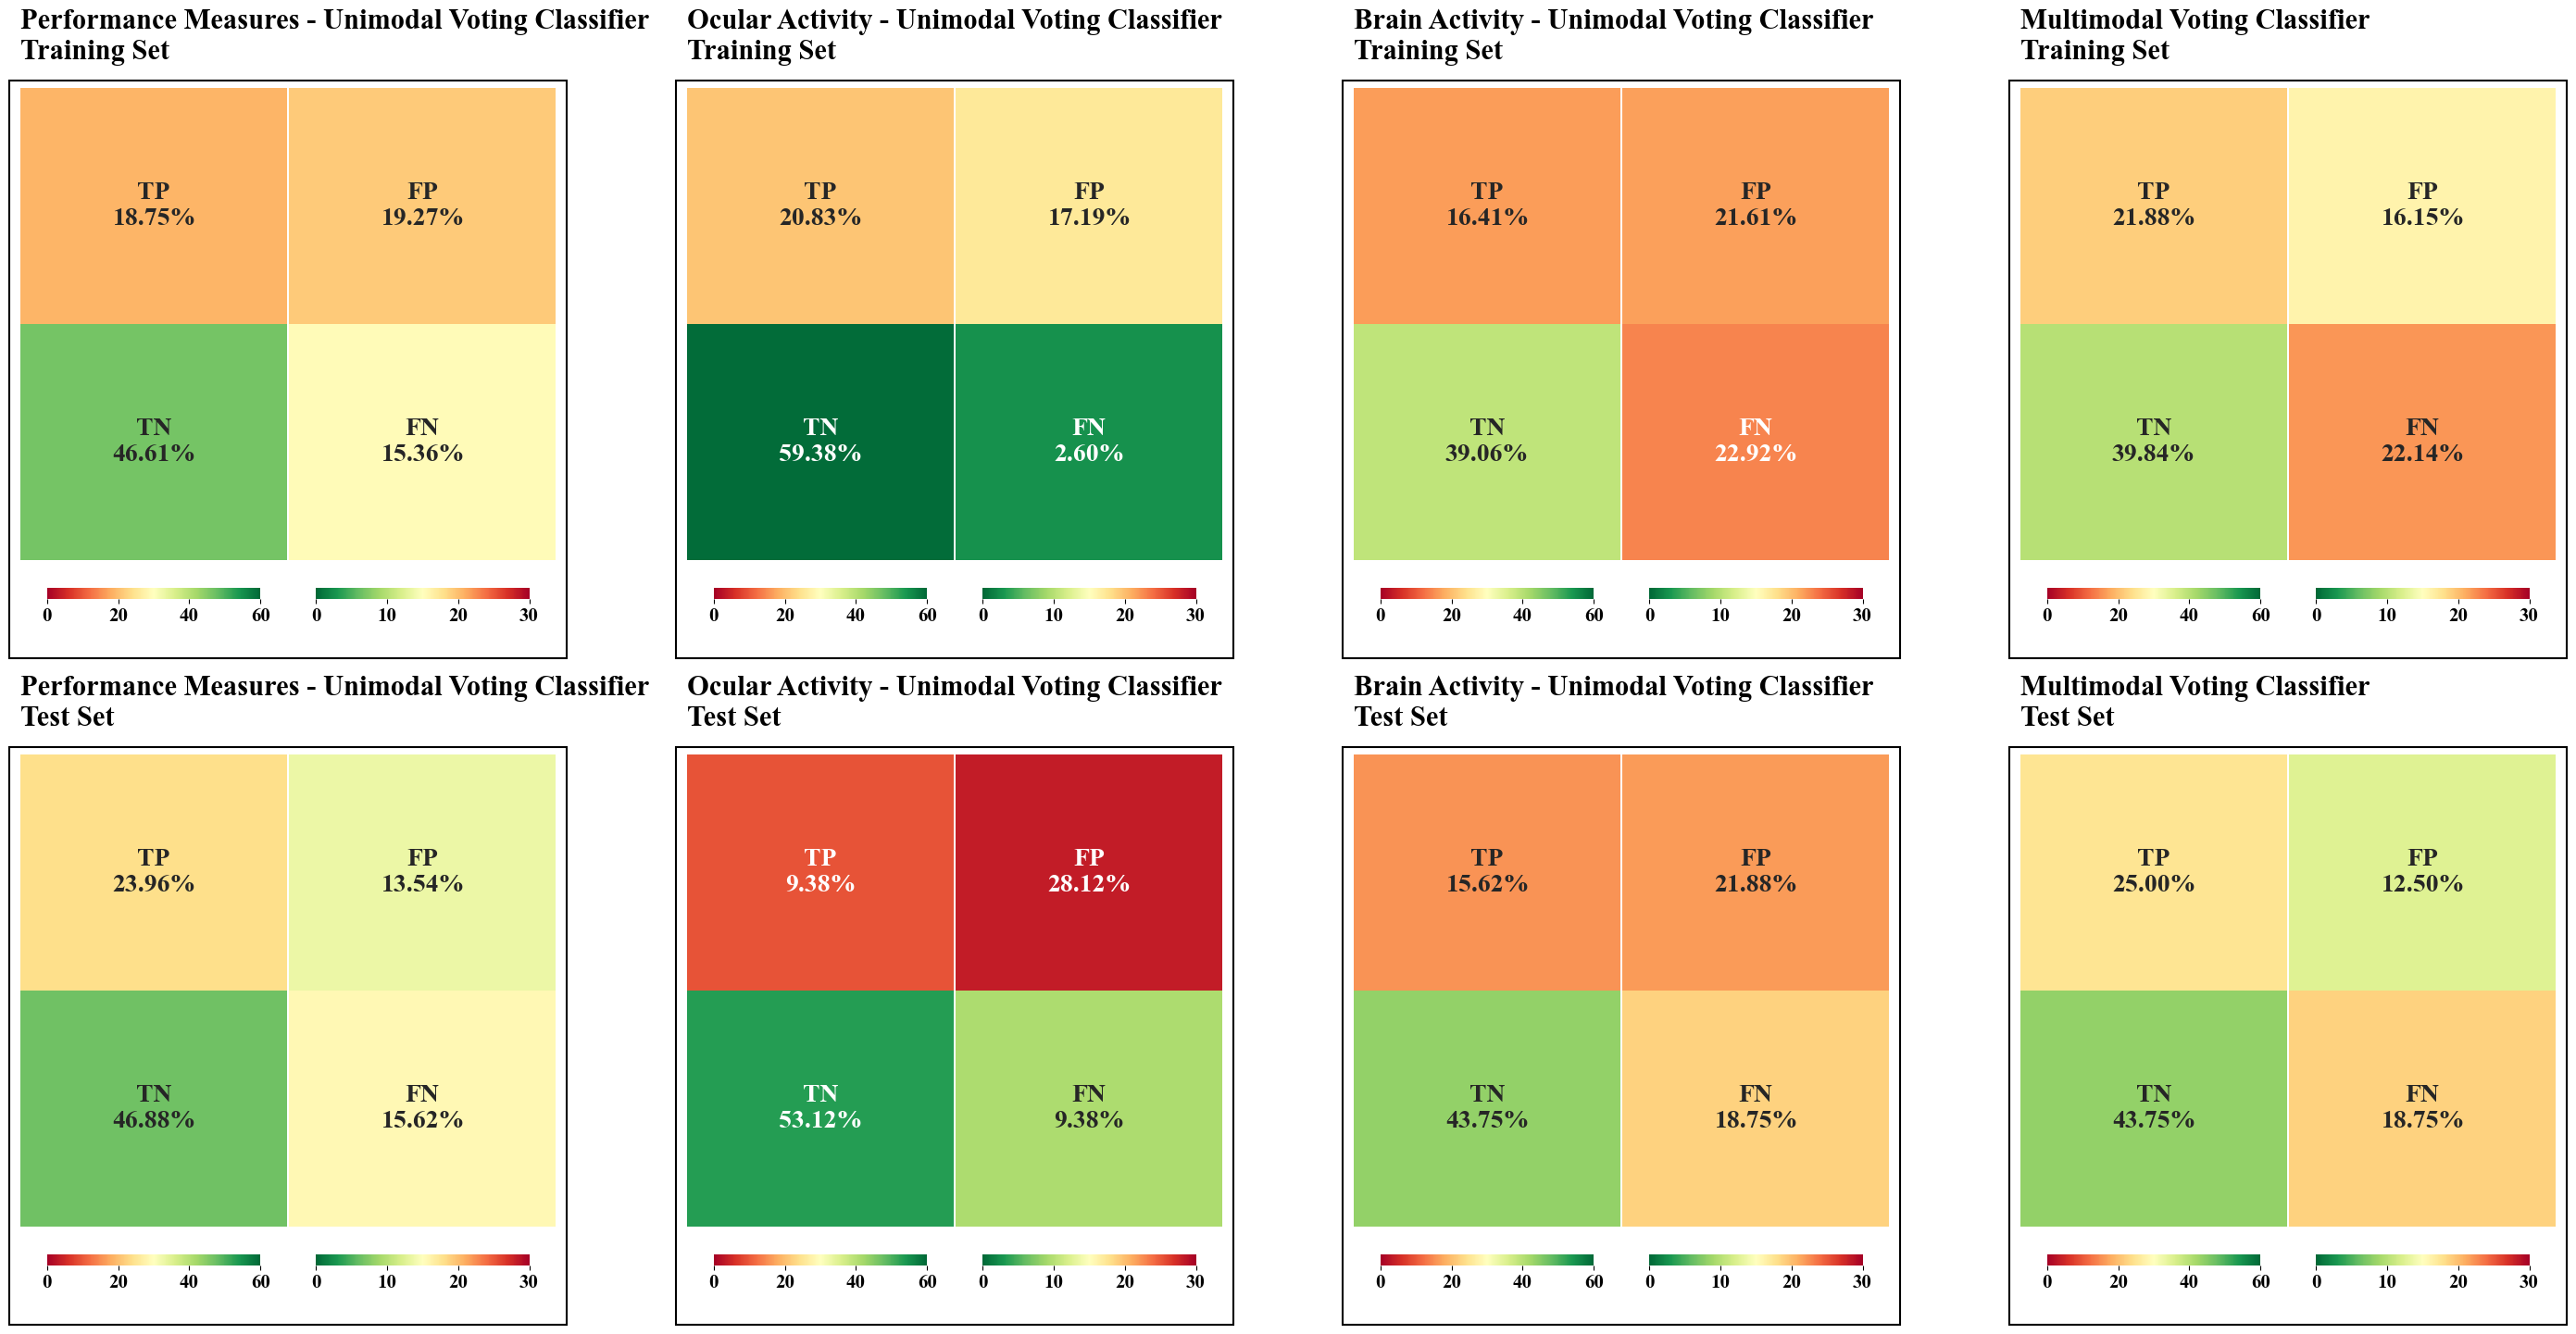

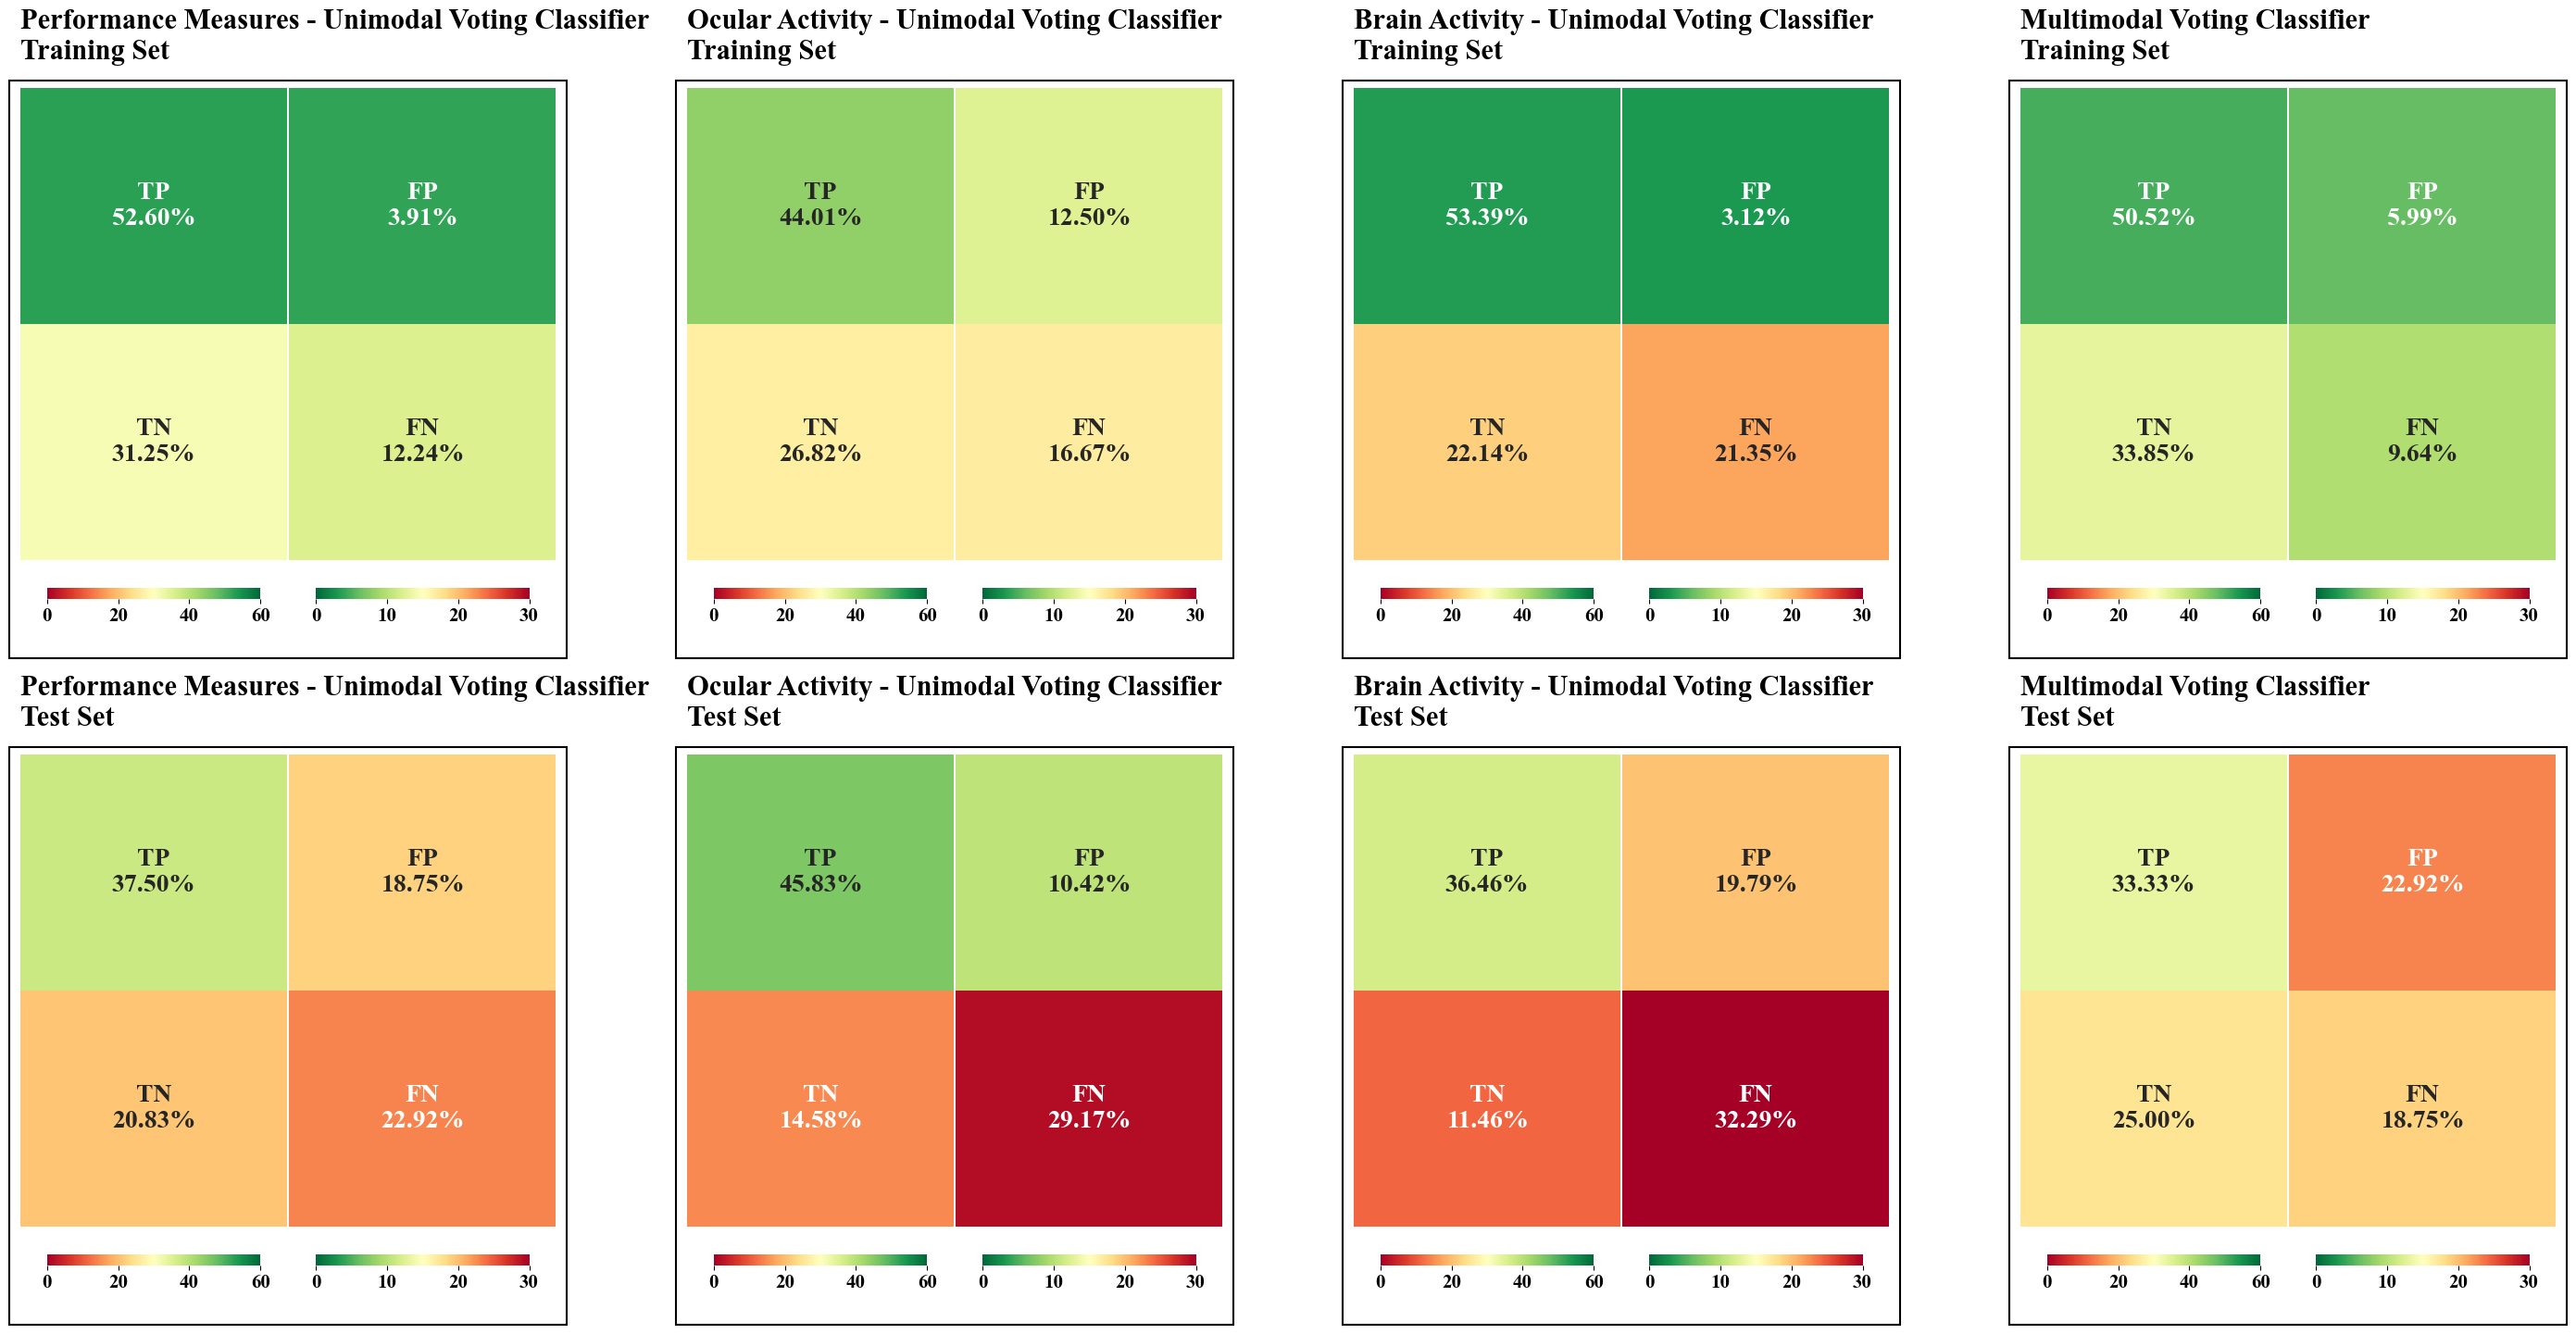

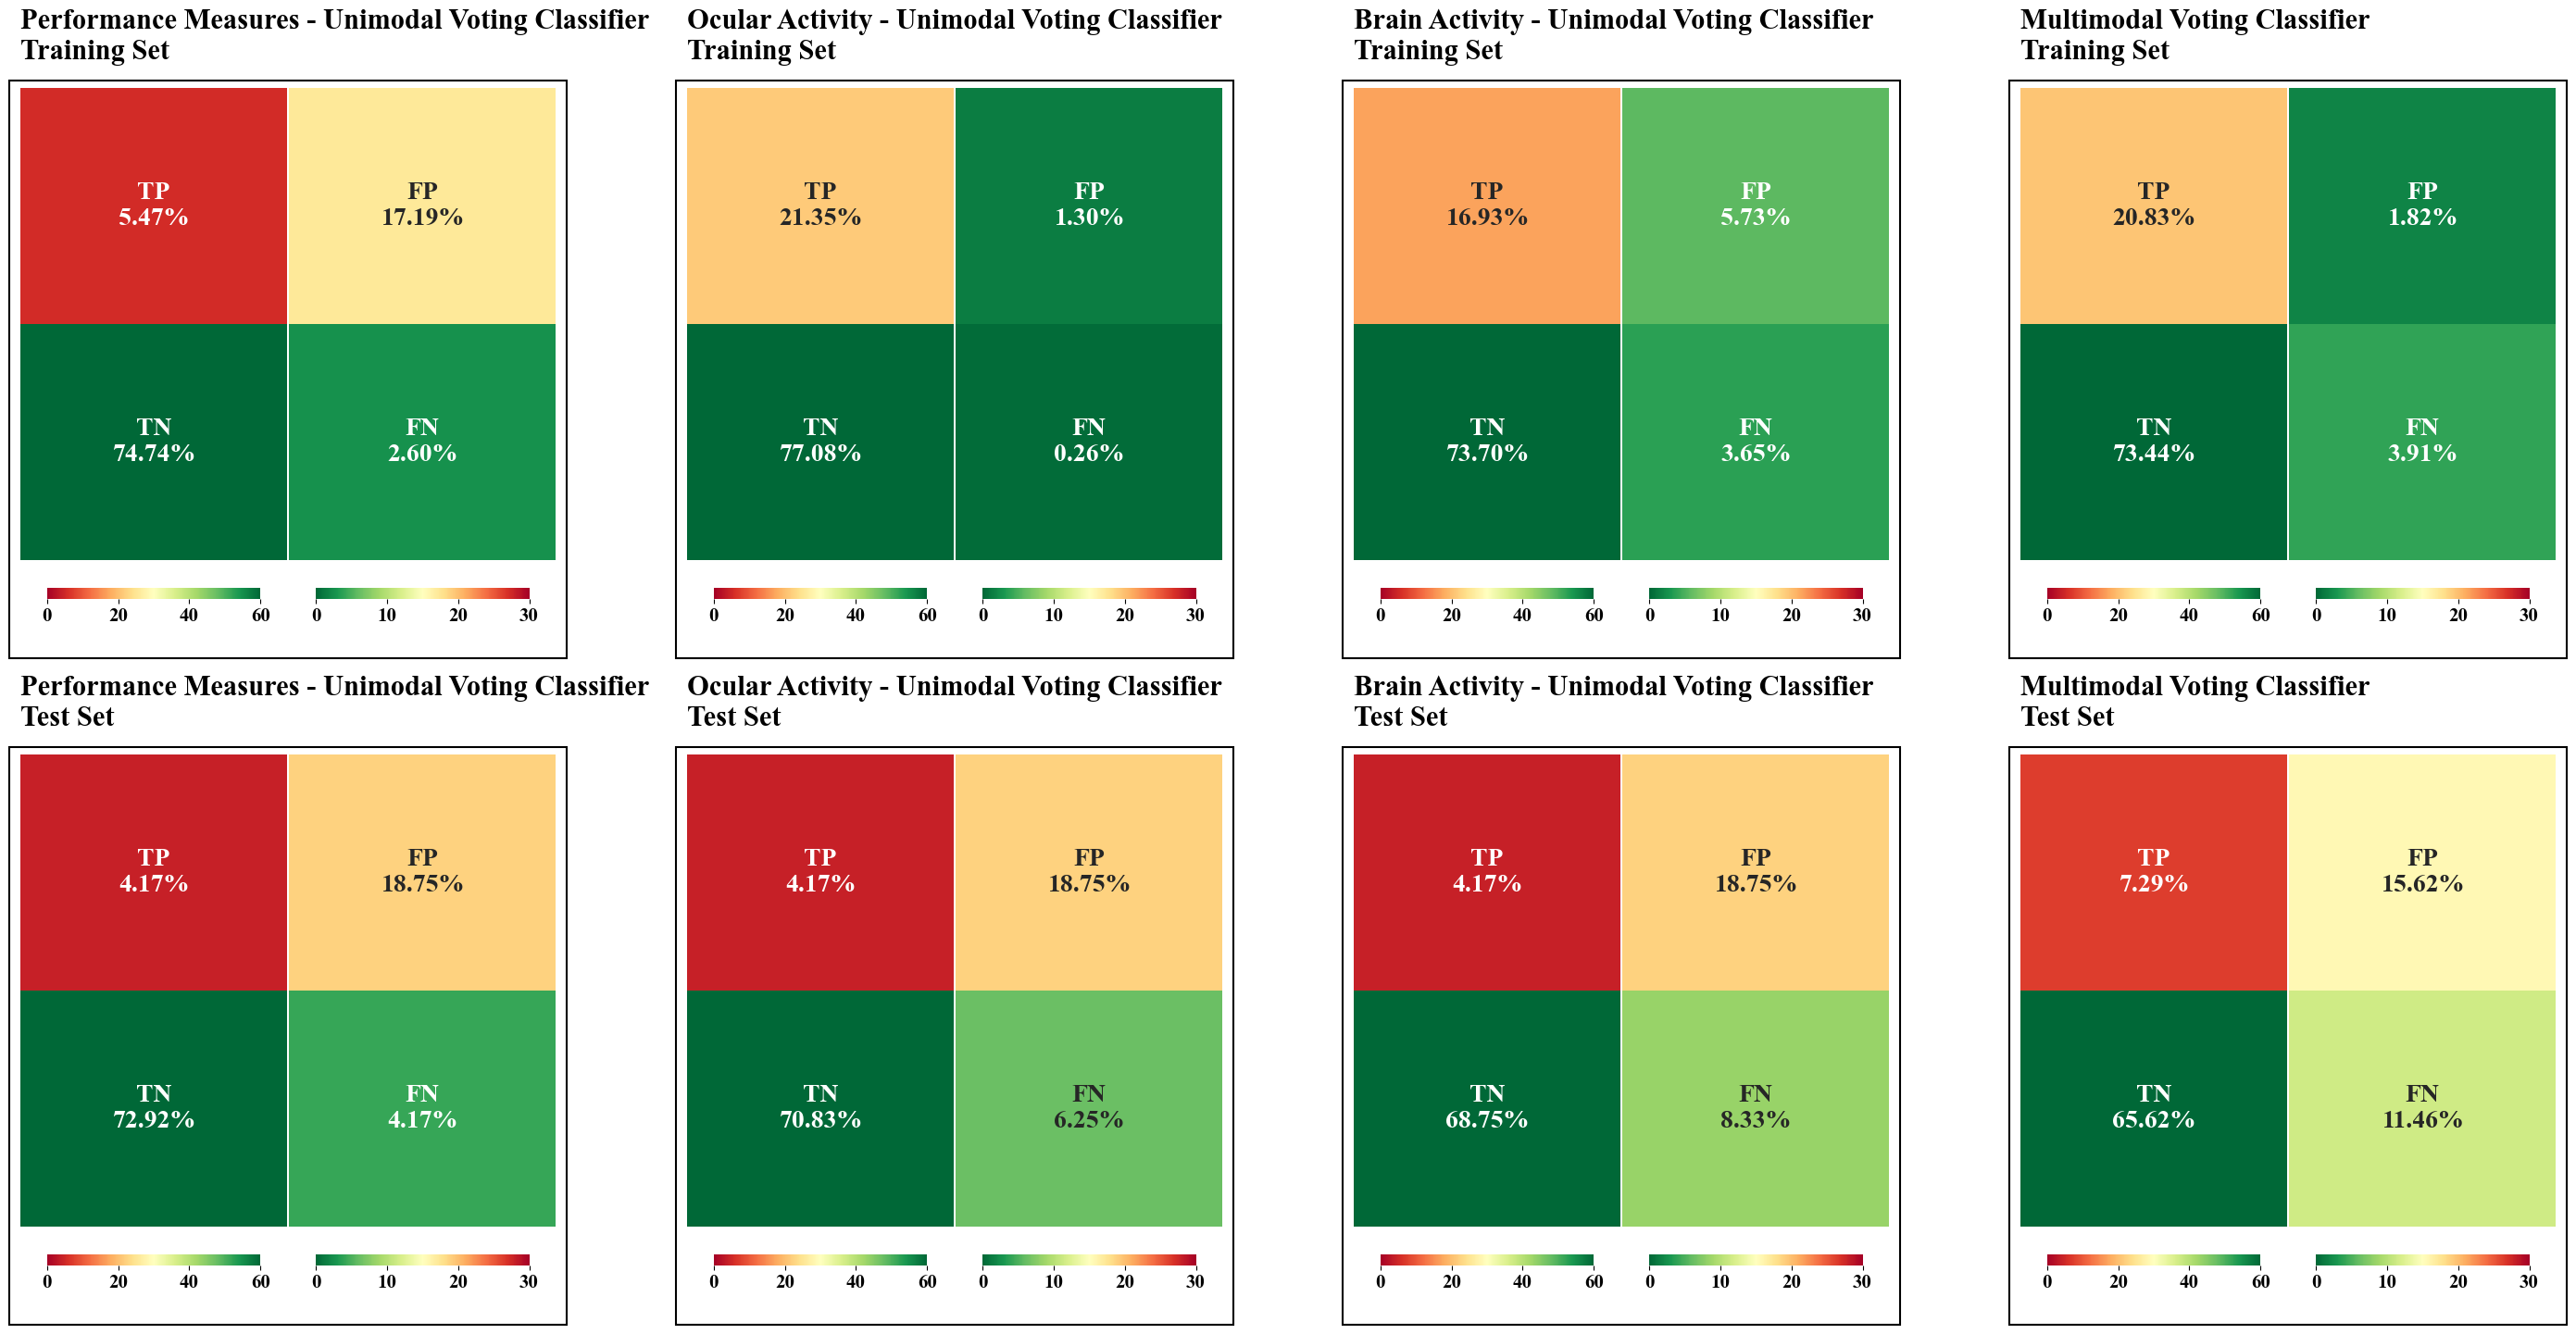

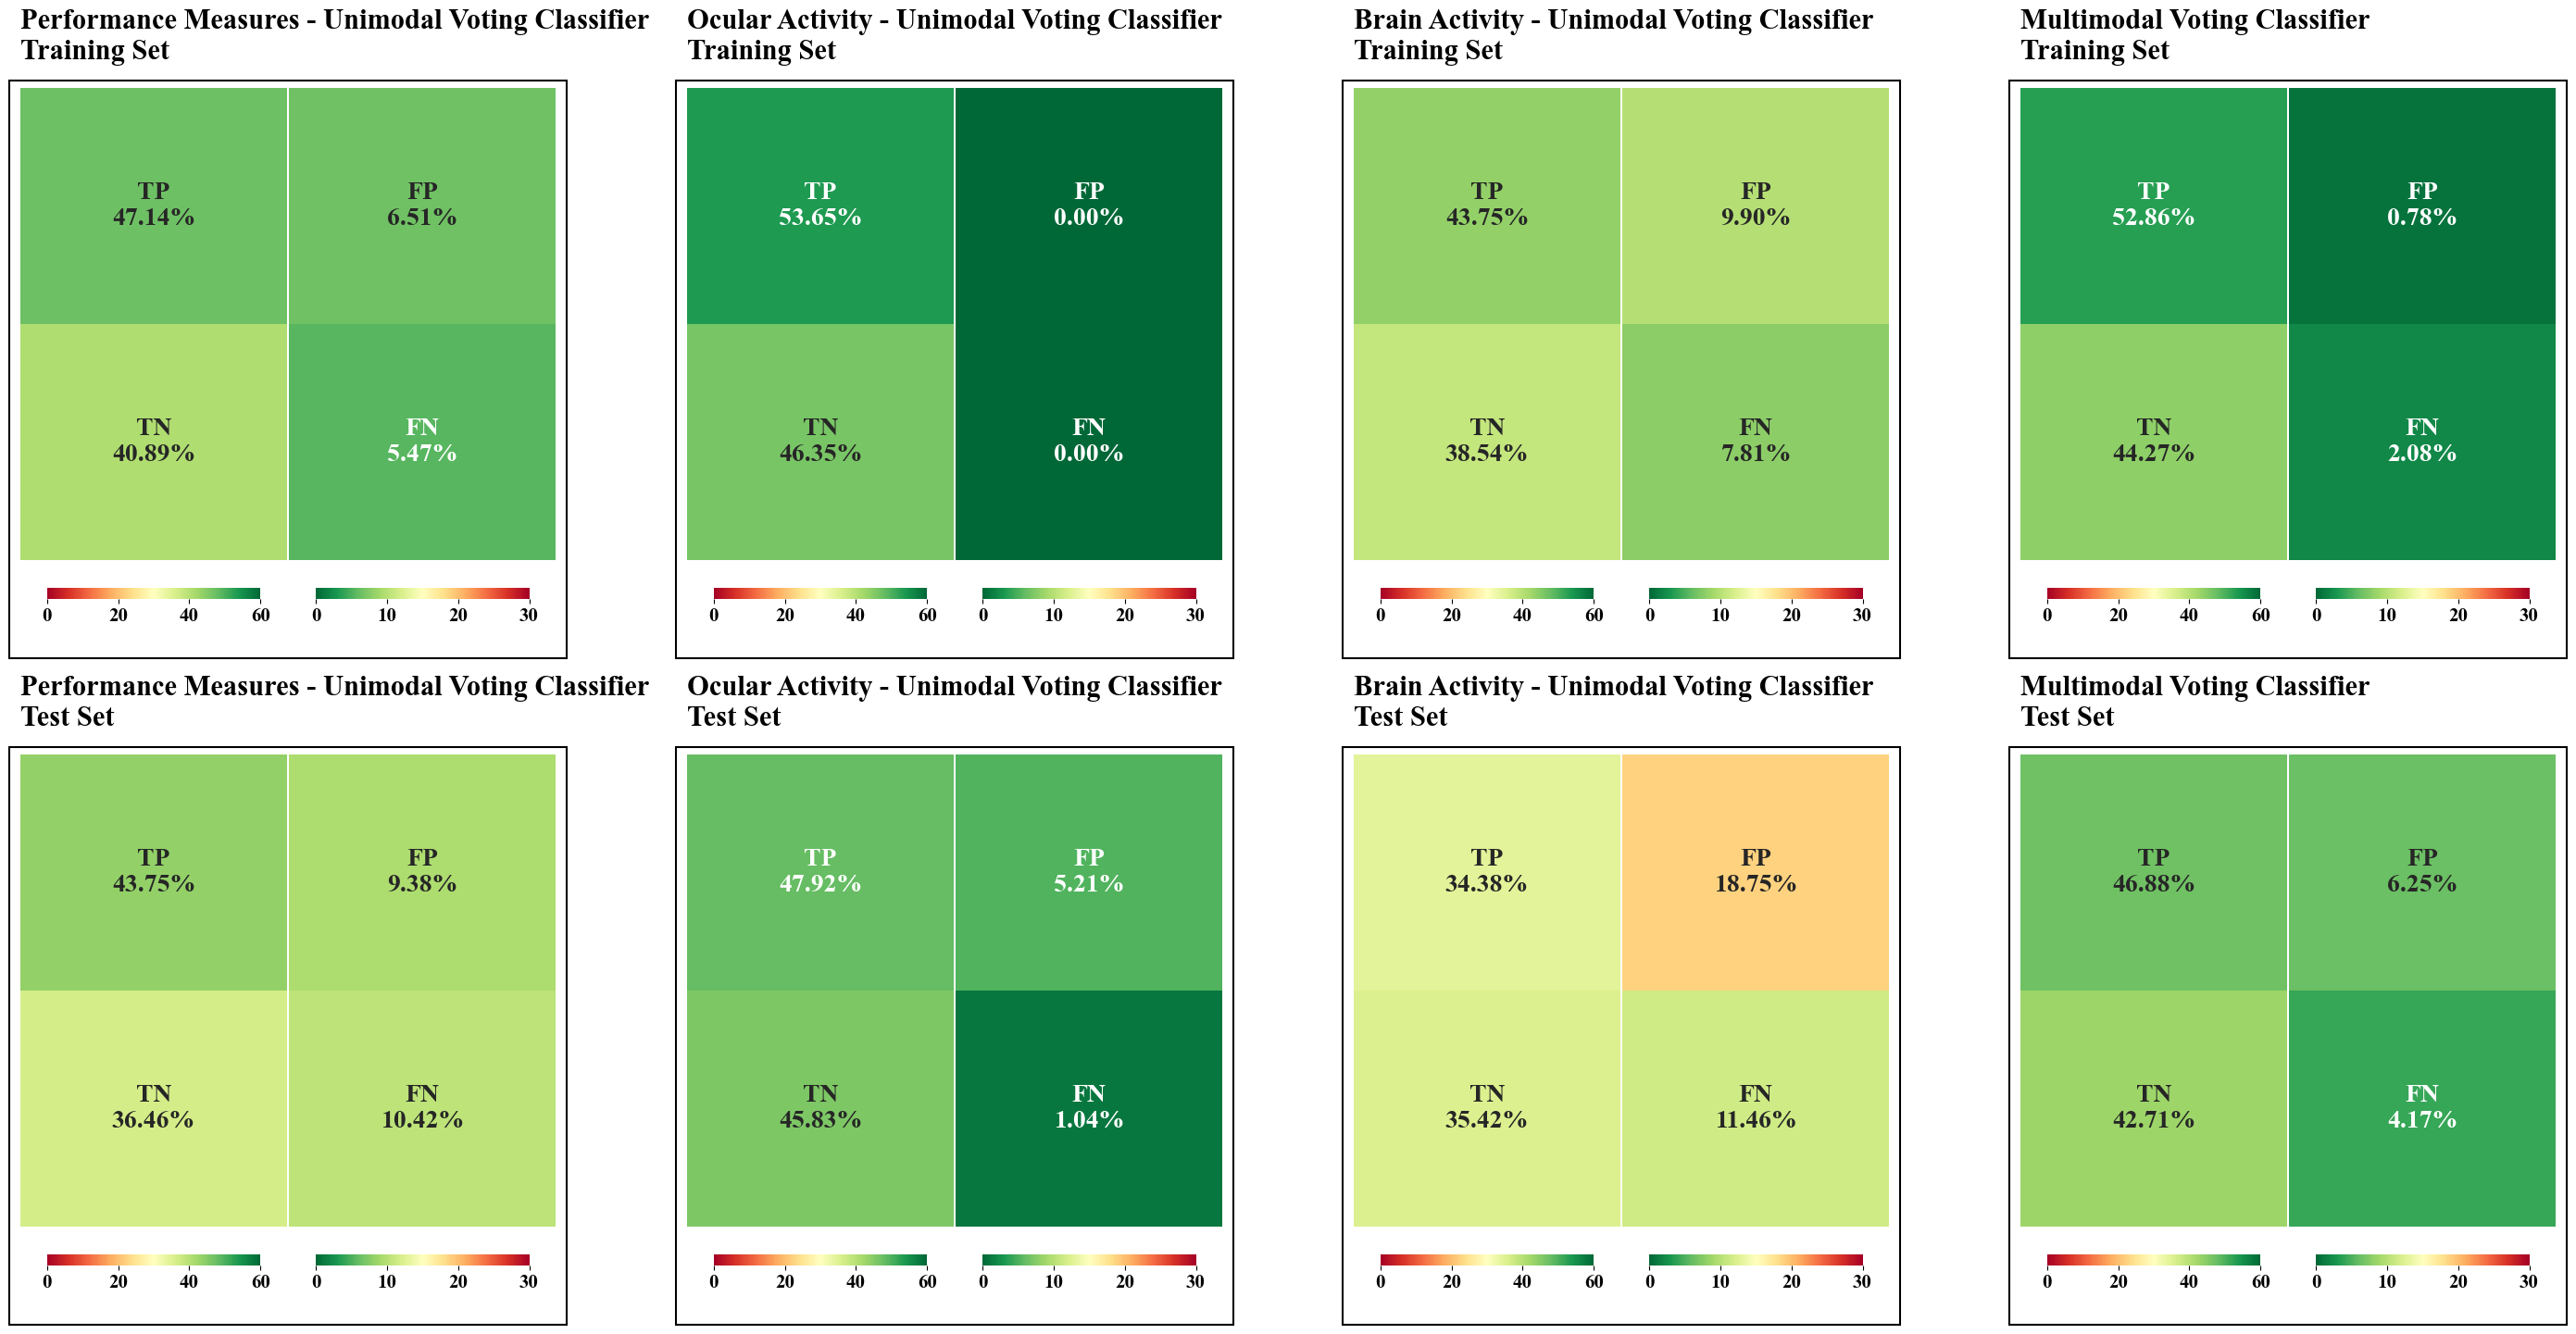

In [52]:
plt.rcParams['font.family'] = 'Times New Roman'

def plot_dual_scale_conf_matrix(matrix, title, fig, position):
    """
    Plots a confusion matrix with two separate color scales and a thin black border.
    """
    matrix = np.array(matrix)
    total = np.sum(matrix)

    reordered = np.array([
        [matrix[0, 0], matrix[0, 1]],
        [matrix[1, 1], matrix[1, 0]]
    ])
    percent = (reordered / total) * 100

    labels = np.array([
        [f"TP\n{percent[0, 0]:.2f}%", f"FP\n{percent[0, 1]:.2f}%"],  
        [f"TN\n{percent[1, 0]:.2f}%", f"FN\n{percent[1, 1]:.2f}%"],  
    ])

    heatmap_width = 0.12
    heatmap_height = 0.75
    spacing = 0.001  

    # Left (TP/TN): 0–60, red→green
    ax_left = fig.add_axes([position[0], position[1], heatmap_width, heatmap_height])
    heatmap_left = sns.heatmap(
        np.array([[percent[0, 0]], [percent[1, 0]]]),
        annot=np.array([[labels[0, 0]], [labels[1, 0]]]),
        fmt='',
        cmap='RdYlGn',
        vmin=0, vmax=60,
        cbar=True,
        cbar_kws={
            "orientation": "horizontal",
            "fraction": 0.1,         
            "pad": 0.05,            
            "shrink": 0.8,         
            "ticks": [0, 20, 40, 60],
        },
        xticklabels=False, yticklabels=False,
        annot_kws={"weight": "bold", "fontsize": 20},  
        ax=ax_left
    )

    heatmap_left.figure.axes[-1].tick_params(labelsize=15)
    [label.set_fontweight('bold') for label in heatmap_left.figure.axes[-1].get_xticklabels()]
    
    # Right (FP/FN): 0–30, green→red
    ax_right = fig.add_axes([
        position[0] + heatmap_width + spacing,
        position[1],
        heatmap_width,
        heatmap_height
    ])
    heatmap_right = sns.heatmap(
        np.array([[percent[0, 1]], [percent[1, 1]]]),
        annot=np.array([[labels[0, 1]], [labels[1, 1]]]),
        fmt='',
        cmap='RdYlGn_r',  
        vmin=0, vmax=30,
        cbar=True,
        cbar_kws={
            "orientation": "horizontal",
            "fraction": 0.1,
            "pad": 0.05,
            "shrink": 0.8,
            "ticks": [0, 10, 20, 30],
        },
        xticklabels=False, yticklabels=False,
        annot_kws={"weight": "bold", "fontsize": 20}, 
        ax=ax_right
        
    )
    
    heatmap_right.figure.axes[-1].tick_params(labelsize=15)
    [label.set_fontweight('bold') for label in heatmap_right.figure.axes[-1].get_xticklabels()]
    
    # Add the border
    border_x = position[0] - 0.005 
    border_y = position[1] - 0.02  
    border_width = 2 * heatmap_width + spacing + 0.01  
    border_height = heatmap_height + 0.03  

    rect = patches.Rectangle(
        (border_x, border_y), border_width, border_height,
        linewidth=1.5, edgecolor='black', facecolor='none'
    )
    fig.add_artist(rect)
    fig.text(position[0], position[1] + heatmap_height + 0.04,
             title, ha='left', fontsize=22, fontweight='bold')


for label in results_df['label'].unique():
    subset = results_df[results_df['label'] == label].reset_index(drop=True)
    n_models = len(subset)

    fig = plt.figure(figsize=(6 * n_models, 8))  
    #fig.text(0.5, 1.2, f"Confusion Matrices for Label: {label}", ha='center', fontsize=16, fontweight='bold')

    for i, (_, row) in enumerate(subset.iterrows()):
        classifier = "Voting Classifier"
        modality = row['modality'].capitalize()

        if modality == "Brain_activity":
            modality_name = "Brain Activity - Unimodal"
        elif modality == "Eye_tracking":
            modality_name = "Ocular Activity - Unimodal"
        elif modality == "Behavioral":
            modality_name = "Performance Measures - Unimodal"
        elif modality == "All":
            modality_name = "Multimodal"
        else:
            modality_name = modality

        title_train = f"{modality_name} {classifier}\nTraining Set"
        title_test = f"{modality_name} {classifier}\nTest Set"

        pos_x = 0.05 + i * 0.3
        pos_y_train = 1.3  
        pos_y_test = 0.4   
         
        plot_dual_scale_conf_matrix(row['train_confusion_matrix'],
                                    title_train, fig, (pos_x, pos_y_train))
        plot_dual_scale_conf_matrix(row['test_confusion_matrix'],
                                    title_test, fig, (pos_x, pos_y_test))

    plt.show()